<a href="https://colab.research.google.com/github/WTWalters/100-days-of-code/blob/master/Copy_of_Sarcasm_Detection_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sarcasm Detection with Tensorflow

From Kaggle:
https://www.kaggle.com/code/dawidcegielski/sarcasm-detection-with-tensorflow-97-acc/notebook

##Imports

###Kaggle configuration

Install Kaggel

In [ ]:
!pip install kaggle

Make a directory for the Kaggle API Key

In [ ]:
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


Step 1) Download your Kaggle key (kaggle.json) to your local drive

Step 2) Upload you Kaggle key to Colab (its the up arrow in the left corner)

Step 3) Copy the key to the ~/.kaggle folder

Step 4) Change the permission

In [ ]:
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


List the Kaggle data sets

In [ ]:
!kaggle datasets list


ref                                                              title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          15248        317  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                      2MB  2024-04-29 19:29:56           2817         56  1.0              
kapturovalexander/time-series-for-online-store                   🏪🏬🪫 Electronic store sales data                      9MB  2024-04-30 09:33:41           1055         28  1.0              
fahadrehman07/retail-transaction-dataset                    

List the Kaggle data sets like 'sarcasm'

In [ ]:
!kaggle datasets list -s 'sarcasm'

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
danofer/sarcasm                                                 Sarcasm on Reddit                               216MB  2018-05-27 08:19:04          11656        250  1.0              
rmisra/news-headlines-dataset-for-sarcasm-detection             News Headlines Dataset For Sarcasm Detection      3MB  2019-07-03 23:52:57          44662        979  1.0              
saurabhbagchi/sarcasm-detection-through-nlp                     Sarcasm detection                                 2MB  2021-03-20 08:31:15           1245         13  1.0              
nikhiljohnk/tweets-with-sarcasm-and-irony                       Tweets with Sarc

Download the Sarcasm dataset

In [ ]:
!kaggle datasets download -d 'rmisra/news-headlines-dataset-for-sarcasm-detection'

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


Import our classes

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

Use pandas to read the json files into dataframes

In [ ]:
data1 = pd.read_json(open("Sarcasm_Headlines_Dataset_v2.json", "r"),lines=True)
data2 = pd.read_json(open("Sarcasm_Headlines_Dataset.json", "r"),lines=True)
df = pd.concat([data1, data2], ignore_index=True)
df.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  55328 non-null  int64 
 1   headline      55328 non-null  object
 2   article_link  55328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


##EDA

<ipython-input-88-fd424bbdfb5d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")


Text(0.5, 1.0, 'Countplot of headlines')

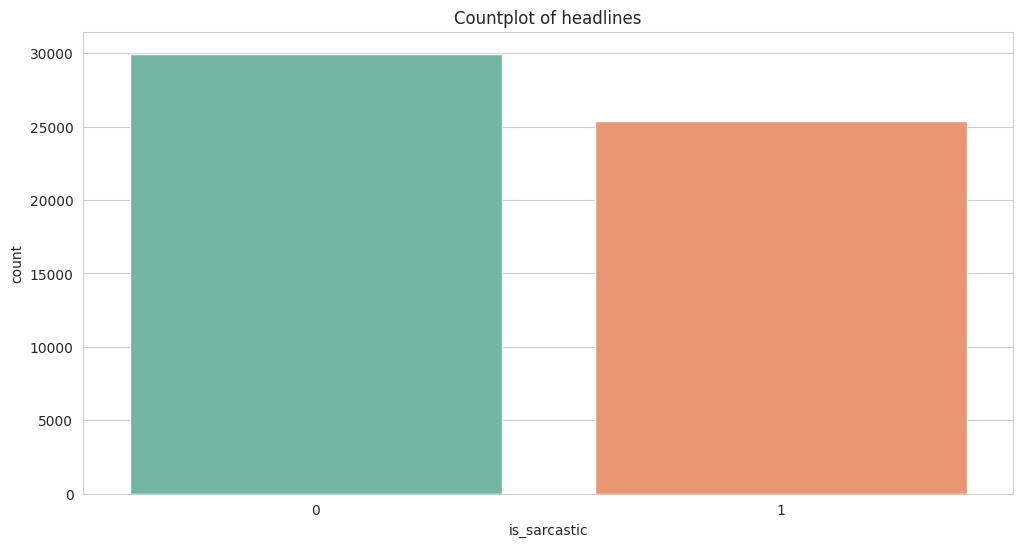

In [ ]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [ ]:
# Add new column 'headline_len': Text length of headline
df['headline_len'] = df['headline'].map(len)

In [ ]:
# Define function which takes full article link and extract string with website name
def extract_website(link):
  return link.split('//')[1].split('.com')[0].replace('www.', "")

In [ ]:
# Apply extract_website func to df article_link and create new column with website name
df['website'] = df['article_link'].apply((lambda x: extract_website(x)))

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'theonion'),
  Text(1, 0, 'huffingtonpost'),
  Text(2, 0, 'local.theonion'),
  Text(3, 0, 'politics.theonion'),
  Text(4, 0, 'entertainment.theonion'),
  Text(5, 0, 'sports.theonion'),
  Text(6, 0, 'ogn.theonion')])

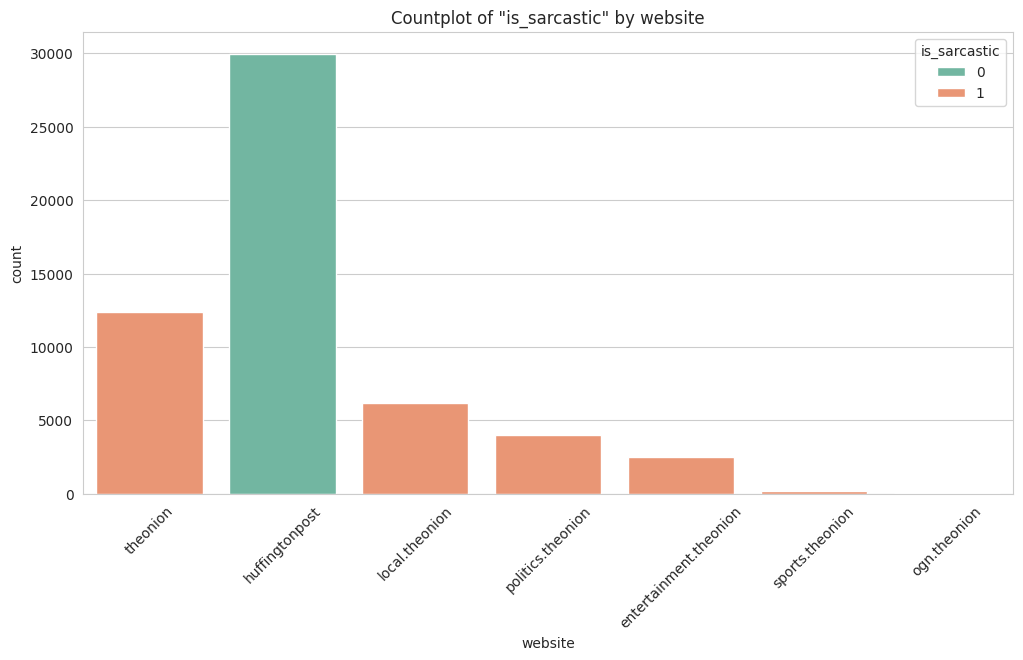

In [ ]:
# Check number of headlines by is_sarcastic for every website
plt.figure(figsize=(12,6))
sns.countplot(data=df, x = 'website', hue='is_sarcastic', palette="Set2").set_title('Countplot of "is_sarcastic" by website')
plt.xticks(rotation=45)

In [ ]:
# Sort dataframe by headline length. Check the longest headline.
df.sort_values(by='headline_len', ascending=False).head(4)

,is_sarcastic,headline,article_link,headline_len,website
7302,1,hot wheels ranked number one toy for rolling d...,https://www.theonion.com/hot-wheels-ranked-num...,926,theonion
2146,1,"maya angelou, poet, author, civil rights activ...",https://www.theonion.com/maya-angelou-poet-aut...,254,theonion
48487,1,"maya angelou, poet, author, civil rights activ...",https://www.theonion.com/maya-angelou-poet-aut...,254,theonion
16588,1,"'12 years a slave,' 'captain phillips,' 'ameri...",https://entertainment.theonion.com/12-years-a-...,238,entertainment.theonion


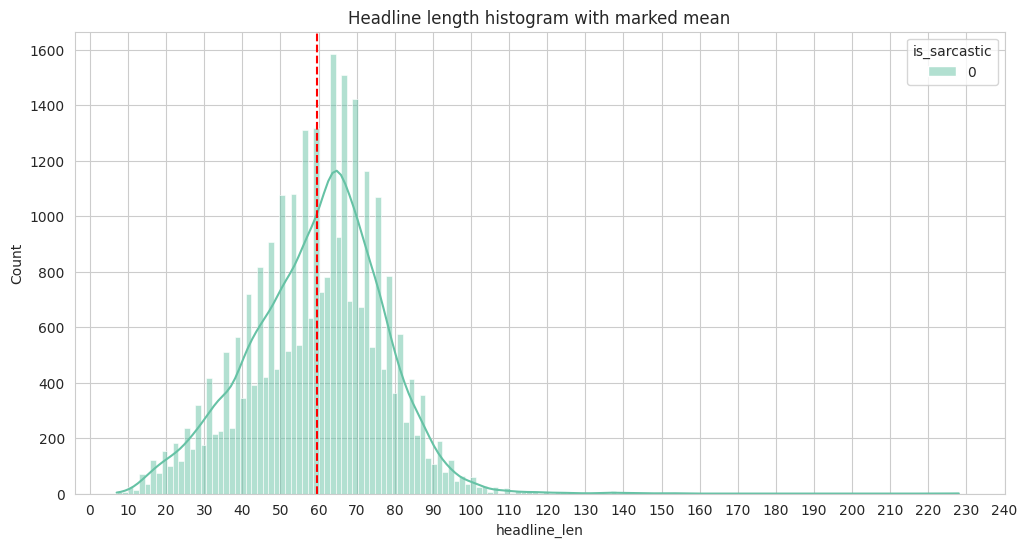

In [ ]:
# Histogram of headline length for not "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)],
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 0
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(),
                color='r', linestyle = '--')

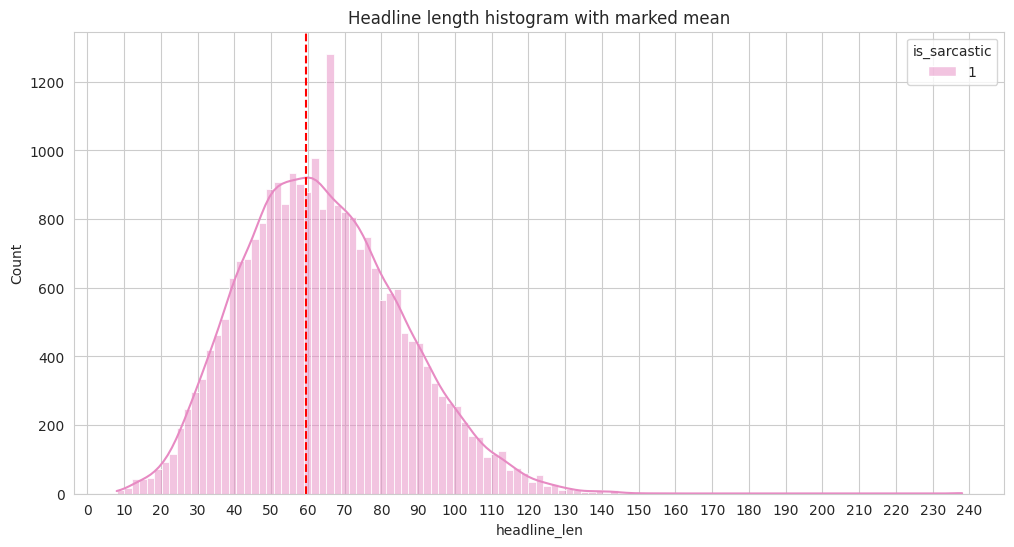

In [ ]:
# Histogram of headline length for "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 1)],
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2_r').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 1
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(),
                color='r', linestyle = '--')

##Data PreProcessing

In [ ]:
# List of stopwords
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
sentences = []
labels = []

# append all headlines text and label (is_sarcastic) to list
for ind, row in df.iterrows():
  labels.append(row['is_sarcastic'])

  sentence = row['headline']
  # remove stopwords in sentences
  for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
      sentence = sentence.replace("  ", " ")
  sentences.append(sentence)

In [ ]:
def clean_sentences(sentences):
    '''
    Make text lowercase, remove text in square brackets,
    remove punctuation and remove words containing numbers.
    '''
    cln_sentences = []
    for text in sentences:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\w*\d\w*', '', text)
      cln_sentences.append(text)
    return cln_sentences

sentences = clean_sentences(sentences)

In [ ]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
training_portion = .7 # train test split 70:30

In [ ]:
# Set the train size using training_portion arg
train_size = int(len(sentences) * training_portion)

# Split
train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

# Check
print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

38729
38729
38729
16599
16599


In [ ]:
# Tokenizing and padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [ ]:
# Prepare labels for model
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(38729,)
(16599,)


##Creating and Training a Model

In [ ]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d_1 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 40)                8040      
                                                                 
 dropout_4 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                820       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                      

In [ ]:
# Fit the model
num_epochs = 10
history = model.fit(train_padded,
                    training_labels_final,
                    epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/10
1211/1211 [==============================] - 46s 37ms/step - loss: 0.6356 - accuracy: 0.6204 - val_loss: 0.4508 - val_accuracy: 0.8279
Epoch 2/10
1211/1211 [==============================] - 39s 32ms/step - loss: 0.4567 - accuracy: 0.8198 - val_loss: 0.3040 - val_accuracy: 0.8943
Epoch 3/10
1211/1211 [==============================] - 37s 31ms/step - loss: 0.3267 - accuracy: 0.8849 - val_loss: 0.2324 - val_accuracy: 0.9212
Epoch 4/10
1211/1211 [==============================] - 39s 33ms/step - loss: 0.2389 - accuracy: 0.9216 - val_loss: 0.1797 - val_accuracy: 0.9423
Epoch 5/10
1211/1211 [==============================] - 38s 31ms/step - loss: 0.1969 - accuracy: 0.9383 - val_loss: 0.1599 - val_accuracy: 0.9503
Epoch 6/10
1211/1211 [==============================] - 37s 31ms/step - loss: 0.1740 - accuracy: 0.9470 - val_loss: 0.1481 - val_accuracy: 0.9551
Epoch 7/10
1211/1211 [==============================] - 38s 32ms/step - loss: 0.1623 - accuracy: 0.9520 - val_loss: 0.1443 -

##Model Evaluation

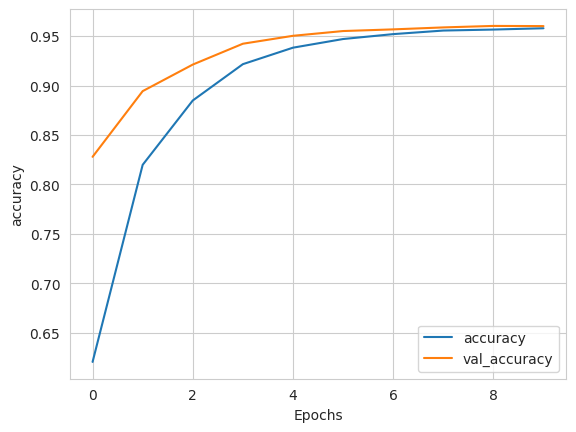

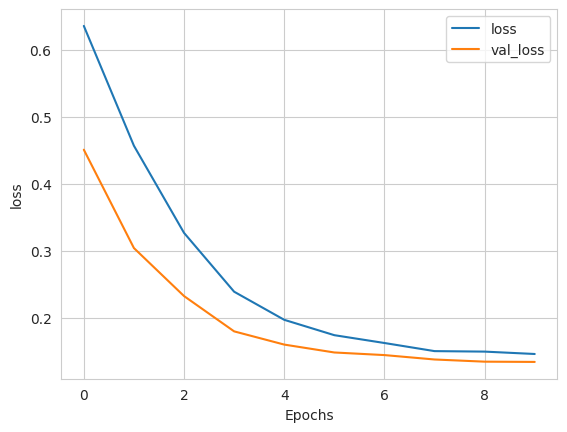

In [ ]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
print("")
plot_graphs(history, "loss")

In [ ]:
# Make prediction
pred = model.predict(validation_padded)


519/519 [==============================] - 2s 4ms/step


In [ ]:
#Make the predictions binary
pred_binary = np.where(pred>0.5, 1.0, 0.0)

In [ ]:
# Print Confusion matrix
print(classification_report(validation_labels, pred_binary, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       1.00      0.93      0.96      9367
    Sarcastic       0.92      0.99      0.96      7232

     accuracy                           0.96     16599
    macro avg       0.96      0.96      0.96     16599
 weighted avg       0.96      0.96      0.96     16599

